[View in Colaboratory](https://colab.research.google.com/github/Hrishi5/RRT_RMP_Project/blob/master/RapidlyExploringRandomTrees.ipynb)

## **Rapidly Exploring Random Trees - Hrishikesh Deshpande**

Rapidly exploring Random Trees(RRTs)

- RRTs is a sampling based method of motion planning where in the free space is sampled randomly and the generated points are added in a data structure similar to a tree or graph.

- These find a special use in high dimensional workspace/C-space and kinodynamic planning with nonholonomic constraints. Nonetheless these can be used for low dimensional space as well but the computational cost may be high as compared to other algorithm depending on the scenario and workspace.

- Performance can be improved by using data structures like KD-Trees when number of nodes is large

- Additional language/environment specific optimizations are also useful. Eg using lower level languages like C/C++ .



### **Code for Nonholonomic Motion**

Implemented Features:
- Custom input from user and construction of workspace according to it.
- Input for start and goal points
- Building RRT under nonholonomic constraints.
- Displaying the built RRT on cartesian plane.
- Allowing to input the obstacle info and thus generate an obstacle at a desired location of predefined size.

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
import matplotlib as mpl
import math
from math import *

In [0]:
class TreeNode():
    
    def __init__(self,data,parent=None):
        self.parent = parent
        self.data = data ;
        self.child = [] ;
        
    def addChild(self,treeNode):
        self.child.append(treeNode)
    
    def removeLastChild(self):
        return self.child.pop() ;
    
    def removeChildByIndex(self,index):
        return self.child.pop(len(self.child)-1-index)

In [0]:
shape_dict_str = {'1':'square','2':'rectangle','3':'triangle'}
shape_dict = {1:'square',2:'rectangle',3:'triangle'}
vert_dict = {'0':'A','1':'B','2':'C','3':'D'}
class obstacle():
    
    def __init__(self,t,x,y,theta,w,h):
        self.typ = t
        self.xa = x
        self.ya = y
        self.w = w
        self.h = h
        self.theta = (theta * np.pi)/180
        self.thetad = theta
        self.shape = shape_dict[t]
        self.vertices = []
        self.vertices.append((self.xa,self.ya))
        self.vert_x = []
        self.vert_y=[]
        self.get_vertices()
    
    def __str__(self):
        return self.shape + ' ' + str(self.vertices)
    
    def sign(self,va, vb, vc):
        return (va[0] - vc[0]) * (vb[1] - vc[1]) - (vb[0] - vc[0]) * (va[1] - vc[1])
    
    def collidesWith(self,p):
        if self.typ == 3:
            b1 = self.sign(p, (self.xa,self.ya), (self.xb,self.yb)) < 0.0
            b2 = self.sign(p, (self.xb,self.yb), (self.xc,self.yc)) < 0.0
            b3 = self.sign(p, (self.xc,self.yc), (self.xa,self.ya)) < 0.0
            return ((b1 == b2) and (b2 == b3))
        else:
            obs_path = mpl.path.Path([[self.xa,self.ya],[self.xb,self.yb],[self.xc,self.yc],[self.xd,self.yd]])
            isInside = obs_path.contains_points([[p[0],p[1]]])
            return isInside[0] 
        
    def get_vertices(self):
        if self.typ !='3':
            self.xb = self.xa + self.w*np.cos(self.theta)
            self.yb = self.ya + self.w*np.sin(self.theta)
            self.vertices.append((self.xb,self.yb))
            self.xd = self.xa - self.h*np.sin(self.theta)
            self.yd = self.ya + self.h*np.cos(self.theta)
            self.xc = self.xd + self.w*np.cos(self.theta)
            self.yc = self.yd + self.w*np.sin(self.theta)
            self.vertices.append((self.xc,self.yc))
            self.vertices.append((self.xd,self.yd))
            self.vert_y.append(self.ya)
            self.vert_y.append(self.yb)
            self.vert_y.append(self.yc)
            self.vert_y.append(self.yd)
            self.vert_x.append(self.xa)
            self.vert_x.append(self.xb)
            self.vert_x.append(self.xc)
            self.vert_x.append(self.xd)
        else:
            self.h = self.w * np.sin(np.pi/3)
            alpha = self.thetad + 60
            alpha = (alpha*np.pi)/180
            self.xb = self.xa + self.w * np.cos(self.theta)
            self.yb = self.ya + self.w * np.cos(self.theta)
            self.vertices.append((self.xb,self.yb))
            self.xc = self.xa + self.w * np.cos(alpha)
            self.yc = self.xa + self.w * np.sin(alpha)
            self.vertices.append((self.xc,self.yc))
            self.vert_y.append(self.ya)
            self.vert_y.append(self.yb)
            self.vert_y.append(self.yc)
            self.vert_x.append(self.xa)
            self.vert_x.append(self.xb)
            self.vert_x.append(self.xc)
        
    
        
            
        
        
        

In [0]:
class configuration():
    def __init__(self,xi,yi,thetai,pvel,pphi,dist,index,pindex=0,xp=None,yp=None):
        self.x = xi;
        self.y = yi;
        self.theta = thetai;
        self.x_parent = xp;
        self.y_parent = yp;
        self.theta_parent = thetai;
        self.parent_velocity = pvel; #This is the velocity at the parent node required to reach current node in the tree
        self.parent_steering_angle = pphi; #This is the steering angle at the parent node required to reach current node in the tree. 
        self.distance = dist;
        self.index = index; 
        self.parent_index = pindex;
        

In [0]:
def generate_random_number(ll,ul):
    return (np.random.uniform(ll,ul,1)[0])


def generateRandomWorkspace(size_x,size_y):
    n_obstacles = generate_random_number(0,10)
    n_obstacles = int(np.round(n_obstacles))
    obstacles = []
    w = 30 ;
    h = 20
    
    for i in range(n_obstacles):
        t = int(np.round(generate_random_number(1,3)))
        x = int(np.round(generate_random_number(0,size_x)))
        y=int(np.round(generate_random_number(0,size_y)))
        theta = int(np.round(generate_random_number(0,90)))
        obstacles.append(obstacle(t,x,y,theta,w,h))
    return obstacles

def plotWorkspace(obstacles):
    for i in obstacles:
        plt.subplot(2,1,2)
        plt.plot(i.vert_x,i.vert_y)
    plt.show()
    
def generateWorkspace(t,x,y,orientation,obstacles):
    o = obstacle(t,x,y,orientation,30,40)
    obstacles.append(o)
    

In [0]:
def generateRandomStartGoalPoints(max_vert,min_vert):
    start = [np.random.uniform(-1,1,1),np.random.uniform(min_vert,max_vert,1)]
    goal = [np.random.uniform(min_vert,max_vert,1),np.random.uniform(min_vert,max_vert,1)]
    print(start,goal)
    plt.scatter(start[0],start[1],c='red')
    plt.scatter(goal[0],goal[1],c='green')
    #plt.scatter(verts[0][0][0],verts[0][0][1],c='yellow')
    plt.show()
    return start,goal 
  

In [0]:
def detect_collision(x,y,obstacles):
    p = (x,y)
    for o in obstacles:
        if o.collidesWith(p):
            return True
    return False
            

In [90]:

size_x = int(input('Input the width of the workspace(atleast 200)')) ;
size_y = int(input('Input height of workspace(atleast 200)'))
if size_x < 200:
    size_x = 200
if size_y < 200:
    size_y = 200


Input the width of the workspace(atleast 200)500
Input height of workspace(atleast 200)500


In [97]:
rand_workspace = input('Do you want to randomly generate workspace ? (Y/N)')
if rand_workspace == 'Y' or rand_workspace == 'y':
    obstacles = generateRandomWorkspace(size_x,size_y)
else:
    n_obstacles = int(input('please enter the number of obstacles(r for random number)'))
    if n_obstacles == 'r' or n_obstacles =='R':
        n_obstcles = np.random.uniform(5,20,1)[0]
    print('Input the type of obstacle')
    print('1.Square\n2.Rectangle\n3.Triangle\n4.Random')
    obstacles = []
    for i in range(n_obstacles):
        t = int(input('Enter type of obstacle ' + str(i+1)))
        if t==4:
            t = np.random.uniform(1,3,1)[0]
        cx = float(input('input x coordinate') )
        cy = float(input('input y coordinate'))
        ctheta = float(input('input orientation of obstacle'))
        generateWorkspace(t,cx,cy,ctheta,obstacles)
print('Generation successful !')
collision = True
while collision:
  start_x = int(input('Enter x coordinate for starting point'))
  start_y = int(input('Enter y coordinate for starting point'))
  collision = detect_collision(start_x,start_y,obstacles)
collision = True
while collision:
  goal_x = int(input('Enter x coordinate for goal point'))
  goal_y = int(input('Enter y coordinate for goal point'))
  collision = detect_collision(start_x,start_y,obstacles)
start = (start_x,start_y)
goal = (goal_x,goal_y)

Do you want to randomly generate workspace ? (Y/N)Y
Generation successful !
Enter x coordinate for starting point20
Enter y coordinate for starting point30
Enter x coordinate for starting point300
Enter y coordinate for starting point400


In [0]:
def getRandomConfiguration(x_max,x_min,y_max,y_min):
    xr = round(generate_random_number(ll=x_min,ul=x_max))
    yr = round(generate_random_number(ll=y_min,ul=y_max));
    theta_rand = generate_random_number(2*np.pi,np.pi/6)
    return xr,yr,theta_rand ;

In [0]:
def getEuclideanDistance(x1,y1,x2,y2):
    d2 = np.square(x2-x1) + np.square(y2-y1)
    return np.sqrt(d2)
    

In [0]:
def getEuclideanDistanceWithAngle(x1,y1,x2,y2,t1,t2):
    pi = np.pi
    d2 = np.square(x2-x1) + np.square(y2-y1) + 200*min([(t1 - t2)**2, (t1 - t2 - 2*pi)**2, (t1-t2 + 2*pi)**2])
    return np.sqrt(d2)
     

In [0]:
def validateTheta(theta_new):
    pi = np.pi
    if theta_new < 0 :
            theta_new = 2*pi - abs(theta_new);
    if theta_new > 2*pi :
            while theta_new > 2*pi :
                theta_new = theta_new - 2*pi
    return theta_new

In [0]:
from matplotlib import patches
def plot_obstacles(obstacles):
    print(obstacles)
    for o in obstacles:
        if o.typ != 3:
            t = plt.Rectangle(xy=[o.xa,o.ya],width=o.w,height=o.h)
        else:
            t = plt.Polygon([[o.xa,o.ya],[o.xb,o.yb],[o.xc,o.yc]])
        plt.gca().add_patch(t)

In [0]:
import time
def getCurrentTime():
  return int(round(time.time() * 1000))

### **Code for building RRT using Nonholonomic Constraints**

In [0]:
def build_non_holonomic_tree(n_iter,start,goal,obstacles,step_size):
  root = TreeNode((start_x,start_y))
  root.data = configuration(xi=start_x,yi=start_y,thetai=start_theta,pvel=0,pphi=0,index=0,pindex=0,dist=0)
  tree=[root]
  distances = []
  step_size = step_size
  v = 4
  l=4.5
  car_length = 4.5
  plot_obstacles(obstacles)
  running_times = []
  s_time = getCurrentTime()
  step = 0
  while step <= n_iter:
                  current_min_dist = 0
                  parent_index = 0
                  path=[]

                  new_node_array = []
                  collision = True
                  while collision:
                      xr,yr,tr = getRandomConfiguration(size_x,0,size_y,0)
                      collision = detect_collision(xr,yr,obstacles)
                  
                  x,y,t = tree[0].data.x , tree[0].data.y , tree[0].data.theta
                  current_min_dist = getEuclideanDistanceWithAngle(x,y,xr,yr,t,tr)
                  for i in range(len(tree)):
                      x,y,t = tree[i].data.x , tree[i].data.y , tree[i].data.theta
                      d = getEuclideanDistanceWithAngle(x,y,xr,yr,t,tr)
                      if current_min_dist > d:
                          current_min_dist = d
                          parent_index = i
                  xn,yn,tn = tree[parent_index].data.x , tree[parent_index].data.y,tree[parent_index].data.theta
                  cphi = -steering_angle
                  cvel = -v
                  path = []
                  path.append((xn,yn,tn))
                  collision = False
                  prev_dist = getEuclideanDistanceWithAngle(xr,yr,xn,yn,tr,tn)
                  cmi = 0
                  xnew,ynew,tnew = 0,0,0
                  cv = -v
                  cp = -steering_angle
                  dt = 0.3
                  collision = False
                      
                  for cvel in [-v,v]:
                        for piter in range(-45,45,10):
                          cphi = math.radians(piter)
                          for j in range(1,10):
                            
                            path.append(())
                            xj = path[j-1][0] + cvel * np.cos(path[j-1][2])*dt
                            yj = path[j-1][1] + cvel*np.sin(path[j-1][2])*dt
                            tj = path[j-1][2] + (cvel/car_length)*np.tan(cphi)*dt
                            path[j] = (xj,yj,tj)
                            
                            new_dist = getEuclideanDistanceWithAngle(path[j][0],path[j][1],xr,yr,path[j][2],tr)
                            if new_dist < prev_dist:
                              
                              prev_dist = new_dist
                              cmi = j
                              xnew,ynew,tnew = xj,yj,tj
                              cv = cvel
                              cp = cphi
                               
                              
                        
                        
                          
                  cmin = prev_dist
                  xnew,ynew,tnew = xnew,ynew,tnew
                  
                  
                  npvel = cv
                  npsteeringangle = cp
                  dnew = configuration(xi = xnew , yi = ynew , thetai=tnew,pvel=npvel,pphi=npsteeringangle,dist=cmin,index=step,pindex=parent_index)
                  dnew.x_parent = xn
                  dnew.y_parent = yn
                  node = TreeNode(data=dnew)
                  tree.append(node)
                  new_node_array = []
                  #plt.scatter(xnew,ynew,c='b',s=3)
                          
                       
                  path = []
                  path.append((xn,yn,tn))
                  collision = False
                  for k in range(1,step_size):
                    
                    path.append(())
                    xk = path[k-1][0] + npvel * np.cos(path[k-1][2])*dt
                    yk = path[k-1][1] + npvel*np.sin(path[k-1][2])*dt
                    tk = path[k-1][2] + (npvel/car_length)*np.tan(npsteeringangle)*dt
                    path[k] = (xk,yk,tk)
                              
                  if collision == False:
                    
                    step = step + 1        
                            
                    for s in range (1,len(path)):
                        
                        plt.plot([path[s][0],path[s-1][0]],[path[s][1],path[s-1][1]],'k-',linewidth=0.5)
                  else:
                      
                      path=[]
                  
                     

                          

[<__main__.obstacle object at 0x7fc1ce9cea20>, <__main__.obstacle object at 0x7fc1ce9ce9e8>, <__main__.obstacle object at 0x7fc1ce9ce940>, <__main__.obstacle object at 0x7fc1ce9e7dd8>, <__main__.obstacle object at 0x7fc1ce9e7eb8>, <__main__.obstacle object at 0x7fc1ce9e7e10>, <__main__.obstacle object at 0x7fc1ce9e7e48>, <__main__.obstacle object at 0x7fc1ce9e7ef0>, <__main__.obstacle object at 0x7fc1ce9e7f28>]


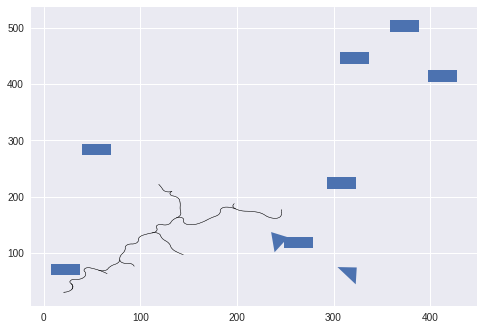

[<__main__.obstacle object at 0x7fc1ce9cea20>, <__main__.obstacle object at 0x7fc1ce9ce9e8>, <__main__.obstacle object at 0x7fc1ce9ce940>, <__main__.obstacle object at 0x7fc1ce9e7dd8>, <__main__.obstacle object at 0x7fc1ce9e7eb8>, <__main__.obstacle object at 0x7fc1ce9e7e10>, <__main__.obstacle object at 0x7fc1ce9e7e48>, <__main__.obstacle object at 0x7fc1ce9e7ef0>, <__main__.obstacle object at 0x7fc1ce9e7f28>]


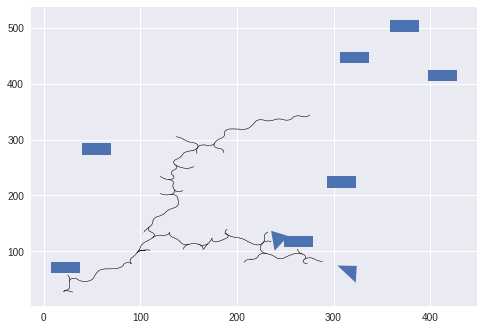

[<__main__.obstacle object at 0x7fc1ce9cea20>, <__main__.obstacle object at 0x7fc1ce9ce9e8>, <__main__.obstacle object at 0x7fc1ce9ce940>, <__main__.obstacle object at 0x7fc1ce9e7dd8>, <__main__.obstacle object at 0x7fc1ce9e7eb8>, <__main__.obstacle object at 0x7fc1ce9e7e10>, <__main__.obstacle object at 0x7fc1ce9e7e48>, <__main__.obstacle object at 0x7fc1ce9e7ef0>, <__main__.obstacle object at 0x7fc1ce9e7f28>]


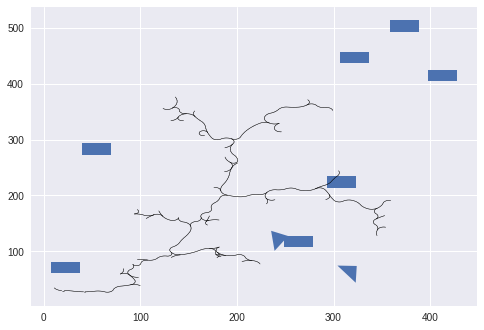

[<__main__.obstacle object at 0x7fc1ce9cea20>, <__main__.obstacle object at 0x7fc1ce9ce9e8>, <__main__.obstacle object at 0x7fc1ce9ce940>, <__main__.obstacle object at 0x7fc1ce9e7dd8>, <__main__.obstacle object at 0x7fc1ce9e7eb8>, <__main__.obstacle object at 0x7fc1ce9e7e10>, <__main__.obstacle object at 0x7fc1ce9e7e48>, <__main__.obstacle object at 0x7fc1ce9e7ef0>, <__main__.obstacle object at 0x7fc1ce9e7f28>]


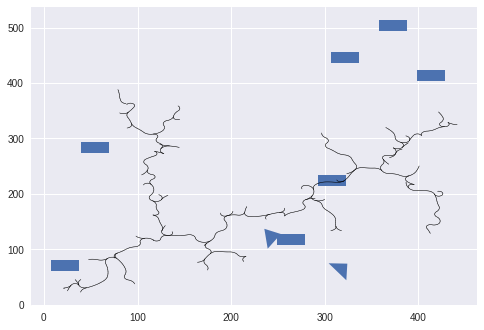

[<__main__.obstacle object at 0x7fc1ce9cea20>, <__main__.obstacle object at 0x7fc1ce9ce9e8>, <__main__.obstacle object at 0x7fc1ce9ce940>, <__main__.obstacle object at 0x7fc1ce9e7dd8>, <__main__.obstacle object at 0x7fc1ce9e7eb8>, <__main__.obstacle object at 0x7fc1ce9e7e10>, <__main__.obstacle object at 0x7fc1ce9e7e48>, <__main__.obstacle object at 0x7fc1ce9e7ef0>, <__main__.obstacle object at 0x7fc1ce9e7f28>]


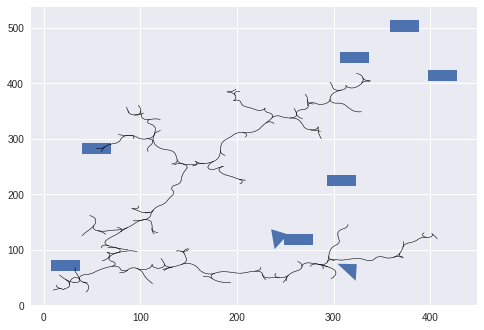

In [148]:
iters = []
running_times = []
start_theta = 0
start = (40,50)
for N in [50,100,150,200,250]:
  s_time = getCurrentTime()
  build_non_holonomic_tree(N,start,goal,obstacles,10)
  e_time = getCurrentTime()
  iters.append(N)
  running_times.append(e_time-s_time)
  plt.show()

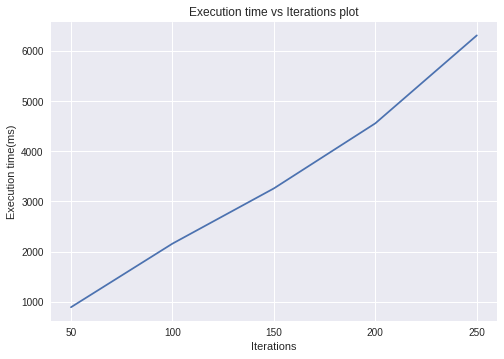

In [149]:
plt.xticks(range(len(running_times)),iters)
plt.xlabel('Iterations')
plt.ylabel('Execution time(ms)')
plt.title('Execution time vs Iterations plot')
plt.plot(range(len(running_times)), running_times)

[<__main__.obstacle object at 0x7fc1ce9cea20>, <__main__.obstacle object at 0x7fc1ce9ce9e8>, <__main__.obstacle object at 0x7fc1ce9ce940>, <__main__.obstacle object at 0x7fc1ce9e7dd8>, <__main__.obstacle object at 0x7fc1ce9e7eb8>, <__main__.obstacle object at 0x7fc1ce9e7e10>, <__main__.obstacle object at 0x7fc1ce9e7e48>, <__main__.obstacle object at 0x7fc1ce9e7ef0>, <__main__.obstacle object at 0x7fc1ce9e7f28>]


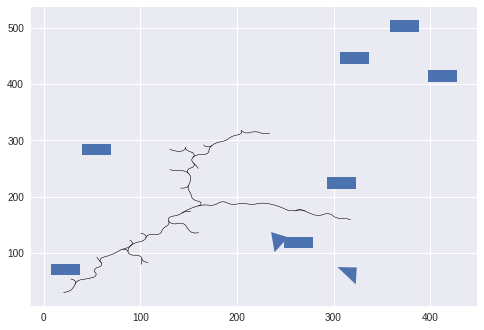

[<__main__.obstacle object at 0x7fc1ce9cea20>, <__main__.obstacle object at 0x7fc1ce9ce9e8>, <__main__.obstacle object at 0x7fc1ce9ce940>, <__main__.obstacle object at 0x7fc1ce9e7dd8>, <__main__.obstacle object at 0x7fc1ce9e7eb8>, <__main__.obstacle object at 0x7fc1ce9e7e10>, <__main__.obstacle object at 0x7fc1ce9e7e48>, <__main__.obstacle object at 0x7fc1ce9e7ef0>, <__main__.obstacle object at 0x7fc1ce9e7f28>]


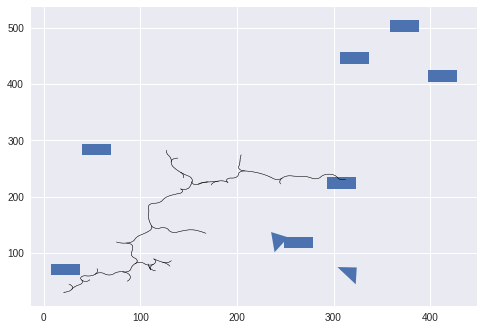

[<__main__.obstacle object at 0x7fc1ce9cea20>, <__main__.obstacle object at 0x7fc1ce9ce9e8>, <__main__.obstacle object at 0x7fc1ce9ce940>, <__main__.obstacle object at 0x7fc1ce9e7dd8>, <__main__.obstacle object at 0x7fc1ce9e7eb8>, <__main__.obstacle object at 0x7fc1ce9e7e10>, <__main__.obstacle object at 0x7fc1ce9e7e48>, <__main__.obstacle object at 0x7fc1ce9e7ef0>, <__main__.obstacle object at 0x7fc1ce9e7f28>]


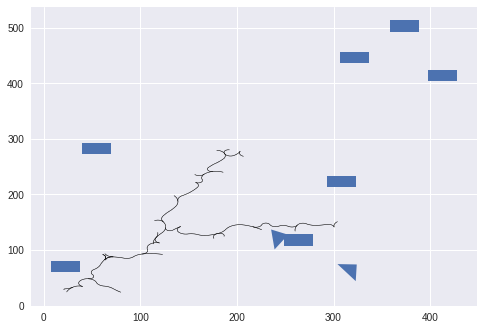

[<__main__.obstacle object at 0x7fc1ce9cea20>, <__main__.obstacle object at 0x7fc1ce9ce9e8>, <__main__.obstacle object at 0x7fc1ce9ce940>, <__main__.obstacle object at 0x7fc1ce9e7dd8>, <__main__.obstacle object at 0x7fc1ce9e7eb8>, <__main__.obstacle object at 0x7fc1ce9e7e10>, <__main__.obstacle object at 0x7fc1ce9e7e48>, <__main__.obstacle object at 0x7fc1ce9e7ef0>, <__main__.obstacle object at 0x7fc1ce9e7f28>]


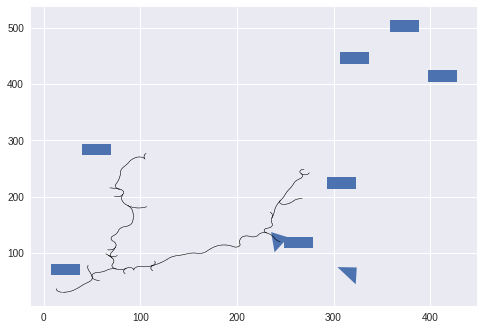

[<__main__.obstacle object at 0x7fc1ce9cea20>, <__main__.obstacle object at 0x7fc1ce9ce9e8>, <__main__.obstacle object at 0x7fc1ce9ce940>, <__main__.obstacle object at 0x7fc1ce9e7dd8>, <__main__.obstacle object at 0x7fc1ce9e7eb8>, <__main__.obstacle object at 0x7fc1ce9e7e10>, <__main__.obstacle object at 0x7fc1ce9e7e48>, <__main__.obstacle object at 0x7fc1ce9e7ef0>, <__main__.obstacle object at 0x7fc1ce9e7f28>]


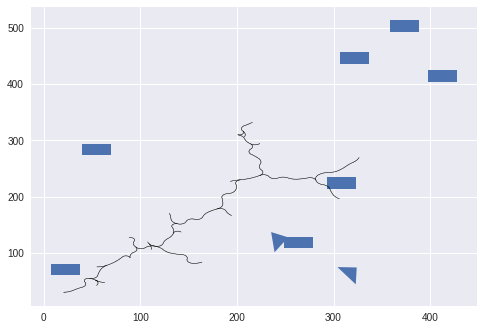

In [127]:
running_times = []
iters=[]
fig,ax = plt.subplots()
for sz in [5,10,20,40,60]:
  s_time = getCurrentTime()
  build_non_holonomic_tree(n_iter=80,start=start,goal=goal,obstacles = obstacles,step_size=10)
  plt.show()
  e_time = getCurrentTime()
  running_times.append(e_time-s_time)
  iters.append(sz)

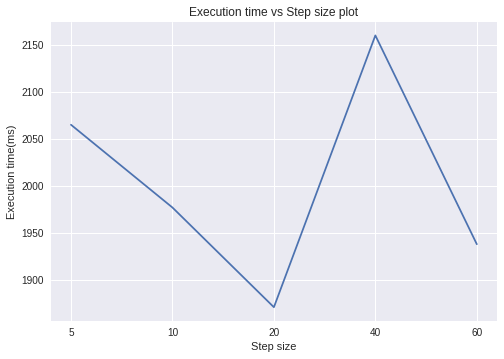

In [128]:
plt.xticks(range(len(running_times)),iters)
plt.xlabel('Step size')
plt.ylabel('Execution time(ms)')
plt.title('Execution time vs Step size plot')
plt.plot(range(len(running_times)), running_times)

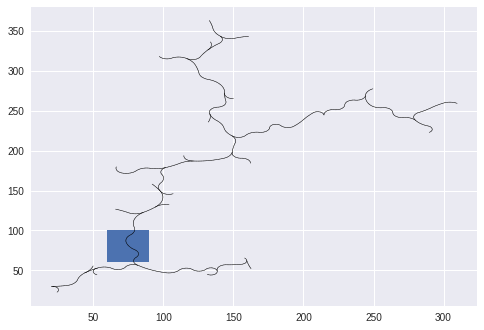

[<__main__.obstacle object at 0x7fc1d0544898>, <__main__.obstacle object at 0x7fc1cea9f908>]


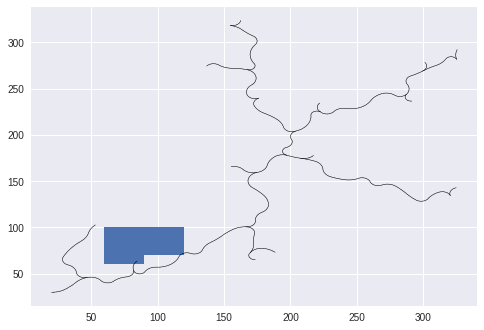

[<__main__.obstacle object at 0x7fc1d0544898>, <__main__.obstacle object at 0x7fc1cea9f908>, <__main__.obstacle object at 0x7fc1db134978>]


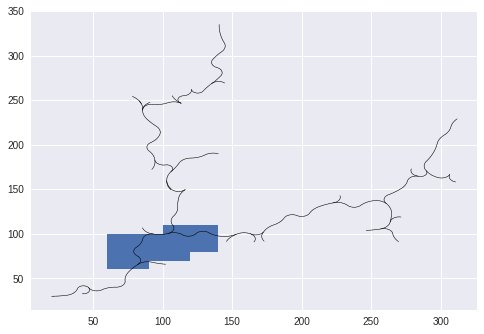

[<__main__.obstacle object at 0x7fc1d0544898>, <__main__.obstacle object at 0x7fc1cea9f908>, <__main__.obstacle object at 0x7fc1db134978>, <__main__.obstacle object at 0x7fc1bcdea128>]


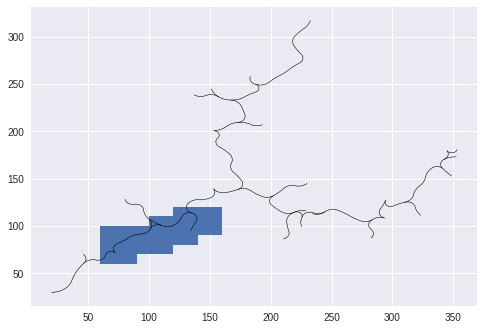

[<__main__.obstacle object at 0x7fc1d0544898>, <__main__.obstacle object at 0x7fc1cea9f908>, <__main__.obstacle object at 0x7fc1db134978>, <__main__.obstacle object at 0x7fc1bcdea128>, <__main__.obstacle object at 0x7fc1d984c518>]


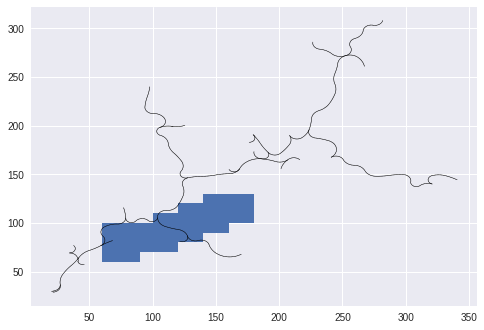

In [129]:
running_times = []
iters=[]
fig,ax = plt.subplots()
o = obstacle(1,60,60,30,30,40)
tobs = [o]
for no in [1,2,3,4,5]:
  s_time = getCurrentTime()
  build_non_holonomic_tree(n_iter=100,start=start,goal=(200,100),obstacles = tobs,step_size=10)
  plt.show()
  e_time = getCurrentTime()
  running_times.append(e_time-s_time)
  iters.append(no)
  to = obstacle(1,tobs[no-1].xa+20,tobs[no-1].ya+10,30+(5*no),40,30)
  tobs.append(to)

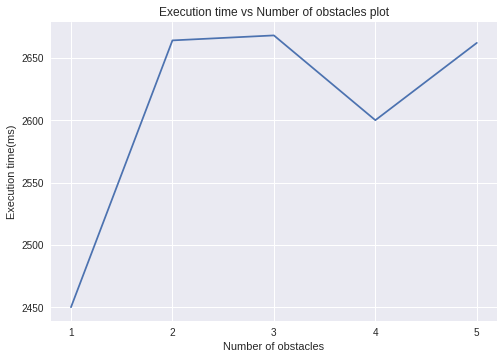

In [130]:
plt.xticks(range(len(running_times)),iters)
plt.xlabel('Number of obstacles')
plt.ylabel('Execution time(ms)')
plt.title('Execution time vs Number of obstacles plot')
plt.plot(range(len(running_times)), running_times)

### **Results**

- The algorithm was able to construct RRT. The tree branches and paths are as expected but is computationally costly and takes time.
- The time required increases exponentially with number of iterations and requires lots of optimization.
- Best results were obtained for parameters car length = 3 , steering_angle = 45 degrees(hence car can rotate 45 degrees to each side) , v = 10, step size = 10
- For lower steering angles, the branches loop around themselves which may or may not be desirable depending on the workspace and the algorithm. Since depending  on the algorithm used for tracing path from start to end , the robot may travel extra distances for loops.
- Step size for distance affects the coverage of the workspace by the tree. Smaller step size covers the workspace slowly.
- It becomes even more time consuming to implement collision detection for robot with finite size instead of a point sized robot
- Collision detection fails in some random cases. The number of such cases is more for nonholonomic.
- Collision detection using finite sized robot could not be implemented

### **Code for Holonomic Motion**

### Implemented features:
- Custom input for start and goal points same as nonholonomic motion RRT
- Allowing user to input obstacle information and thus generate an obstacle at desired location of predefined shape and size.
- Building RRT under no dynamic constraints
- Detecting collision of newly generated point with an obstacle
- Detecting collision of point obtained after extending tree towards random point
- Tracing the trajectory from goal to initial point and displaying the trajectory on a cartesian plane


In [0]:

def build_holonomic_rrt(n_iter,start,goal,obstacles,step_size):
  htree = []
  root = TreeNode(start)
  htree.append(root)
  x_goal = goal[0]
  y_goal = goal[1]
  plot_obstacles(obstacles)
  threshold = 40
  root.data = configuration(xi=start_x,yi=start_y,thetai=start_theta,pvel=0,pphi=0,index=0,pindex=0,dist=0)  
  step = 0
  #plt.scatter([start[0],goal[0]],[start[1],goal[1]],c='r')
  while step <= n_iter:
      xr,yr,tr = getRandomConfiguration(x_max=size_x,x_min=0,y_max=size_y,y_min=0)
      if detect_collision(xr,yr,obstacles):
        continue
      cmi = 0
      cmd = getEuclideanDistance(xr,yr,htree[0].data.x,htree[0].data.y)
      for i in range(len(htree)):
          d = getEuclideanDistance(xr,yr,htree[i].data.x,htree[i].data.y)
          if d < cmd:
            cmd = d
            cmi = i

      distance_value = cmd

      parent_index = cmi
      collision = False
      if distance_value >= step_size:
          x_new = htree[parent_index].data.x + ((xr - htree[parent_index].data.x)*step_size)/distance_value
          y_new = htree[parent_index].data.y + ((yr - htree[parent_index].data.y)*step_size)/distance_value
          if detect_collision(x_new,y_new,obstacles):
            collision = True
      elif distance_value <= step_size:
          x_new = xr;
          y_new = yr;
      if collision:
          continue
      c = configuration(xi = x_new , yi=y_new,index=step,pindex=parent_index,thetai=0,pvel=0,pphi=0,dist=0)
      htree.append(TreeNode(c))
      #plt.scatter(htree[step].data.x, htree[step].data.y,s=10,c='b')
      pind = htree[step].data.parent_index
      px = htree[pind].data.x
      py = htree[pind].data.y
      plt.plot([htree[step].data.x, px], [htree[step].data.y, py],linewidth=2,c='black');
      step = step + 1;
    
  index = 0
  found = False
  for i in htree:
    
    if i.data.x == x_goal and i.data.y == y_goal:
        found = True
        break
    index = index+1
  if found == False:
    print('Did not reach the goal co-ordinates')
    return
  
  if htree[index].data.x == x_goal and htree[index].data.y == y_goal:
      htree[0].data.parent_index = 0
      while parent_index != 0:
        for index in range(len(htree)):
          #print(index,parent_index)
          plt.plot([htree[index].data.x, htree[parent_index].data.x], [htree[index].data.y, htree[parent_index].data.y], linewidth=3,c='g');

          #ax.add_line(line)
          index = parent_index;
          parent_index = htree[index].data.parent_index;    

  
    
    


[<__main__.obstacle object at 0x7fc1ce9cea20>, <__main__.obstacle object at 0x7fc1ce9ce9e8>, <__main__.obstacle object at 0x7fc1ce9ce940>, <__main__.obstacle object at 0x7fc1ce9e7dd8>, <__main__.obstacle object at 0x7fc1ce9e7eb8>, <__main__.obstacle object at 0x7fc1ce9e7e10>, <__main__.obstacle object at 0x7fc1ce9e7e48>, <__main__.obstacle object at 0x7fc1ce9e7ef0>, <__main__.obstacle object at 0x7fc1ce9e7f28>]
Did not reach the goal co-ordinates


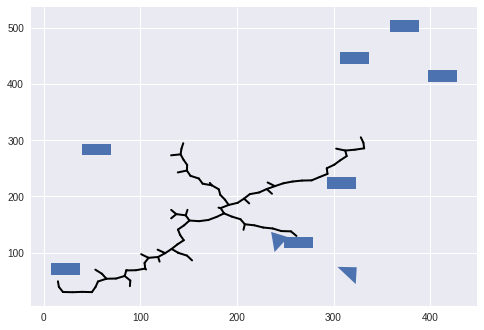

[<__main__.obstacle object at 0x7fc1ce9cea20>, <__main__.obstacle object at 0x7fc1ce9ce9e8>, <__main__.obstacle object at 0x7fc1ce9ce940>, <__main__.obstacle object at 0x7fc1ce9e7dd8>, <__main__.obstacle object at 0x7fc1ce9e7eb8>, <__main__.obstacle object at 0x7fc1ce9e7e10>, <__main__.obstacle object at 0x7fc1ce9e7e48>, <__main__.obstacle object at 0x7fc1ce9e7ef0>, <__main__.obstacle object at 0x7fc1ce9e7f28>]
Did not reach the goal co-ordinates


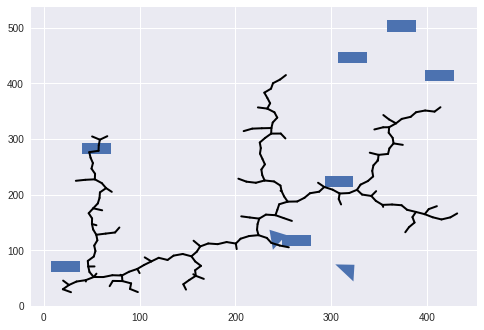

[<__main__.obstacle object at 0x7fc1ce9cea20>, <__main__.obstacle object at 0x7fc1ce9ce9e8>, <__main__.obstacle object at 0x7fc1ce9ce940>, <__main__.obstacle object at 0x7fc1ce9e7dd8>, <__main__.obstacle object at 0x7fc1ce9e7eb8>, <__main__.obstacle object at 0x7fc1ce9e7e10>, <__main__.obstacle object at 0x7fc1ce9e7e48>, <__main__.obstacle object at 0x7fc1ce9e7ef0>, <__main__.obstacle object at 0x7fc1ce9e7f28>]
Did not reach the goal co-ordinates


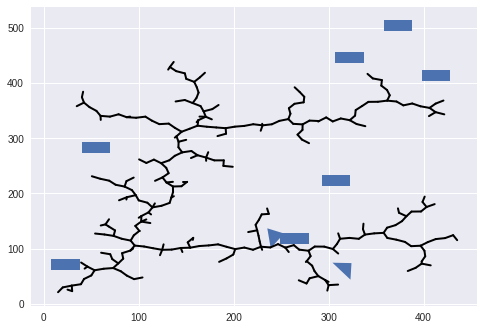

[<__main__.obstacle object at 0x7fc1ce9cea20>, <__main__.obstacle object at 0x7fc1ce9ce9e8>, <__main__.obstacle object at 0x7fc1ce9ce940>, <__main__.obstacle object at 0x7fc1ce9e7dd8>, <__main__.obstacle object at 0x7fc1ce9e7eb8>, <__main__.obstacle object at 0x7fc1ce9e7e10>, <__main__.obstacle object at 0x7fc1ce9e7e48>, <__main__.obstacle object at 0x7fc1ce9e7ef0>, <__main__.obstacle object at 0x7fc1ce9e7f28>]
Did not reach the goal co-ordinates


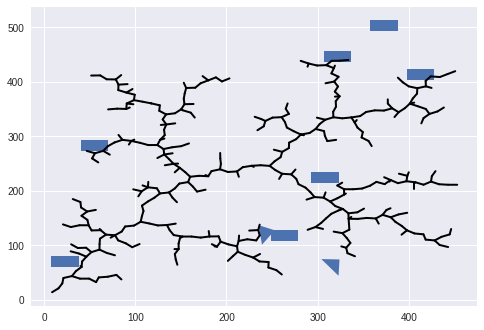

[<__main__.obstacle object at 0x7fc1ce9cea20>, <__main__.obstacle object at 0x7fc1ce9ce9e8>, <__main__.obstacle object at 0x7fc1ce9ce940>, <__main__.obstacle object at 0x7fc1ce9e7dd8>, <__main__.obstacle object at 0x7fc1ce9e7eb8>, <__main__.obstacle object at 0x7fc1ce9e7e10>, <__main__.obstacle object at 0x7fc1ce9e7e48>, <__main__.obstacle object at 0x7fc1ce9e7ef0>, <__main__.obstacle object at 0x7fc1ce9e7f28>]
Did not reach the goal co-ordinates


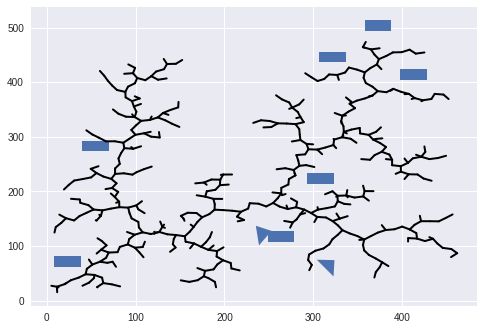

In [139]:
running_times = []
iters=[]
fig,ax = plt.subplots()
for N in [100,200,300,400,500]:
  s_time = getCurrentTime()
  build_holonomic_rrt(n_iter=N,start=start,goal=goal,obstacles = obstacles,step_size=10)
  plt.show()
  e_time = getCurrentTime()
  running_times.append(e_time-s_time)
  iters.append(N)

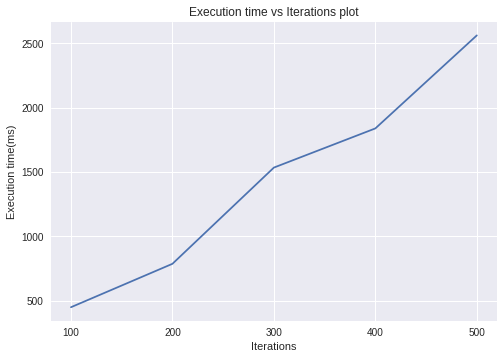

In [140]:
plt.xticks(range(len(running_times)),iters)
plt.xlabel('Iterations')
plt.ylabel('Execution time(ms)')
plt.title('Execution time vs Iterations plot')
plt.plot(range(len(running_times)), running_times)


[<__main__.obstacle object at 0x7fc1ce9cea20>, <__main__.obstacle object at 0x7fc1ce9ce9e8>, <__main__.obstacle object at 0x7fc1ce9ce940>, <__main__.obstacle object at 0x7fc1ce9e7dd8>, <__main__.obstacle object at 0x7fc1ce9e7eb8>, <__main__.obstacle object at 0x7fc1ce9e7e10>, <__main__.obstacle object at 0x7fc1ce9e7e48>, <__main__.obstacle object at 0x7fc1ce9e7ef0>, <__main__.obstacle object at 0x7fc1ce9e7f28>]
Did not reach the goal co-ordinates


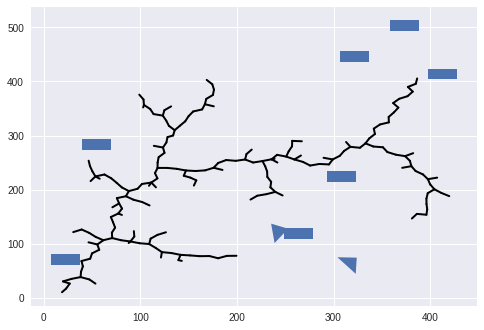

[<__main__.obstacle object at 0x7fc1ce9cea20>, <__main__.obstacle object at 0x7fc1ce9ce9e8>, <__main__.obstacle object at 0x7fc1ce9ce940>, <__main__.obstacle object at 0x7fc1ce9e7dd8>, <__main__.obstacle object at 0x7fc1ce9e7eb8>, <__main__.obstacle object at 0x7fc1ce9e7e10>, <__main__.obstacle object at 0x7fc1ce9e7e48>, <__main__.obstacle object at 0x7fc1ce9e7ef0>, <__main__.obstacle object at 0x7fc1ce9e7f28>]
Did not reach the goal co-ordinates


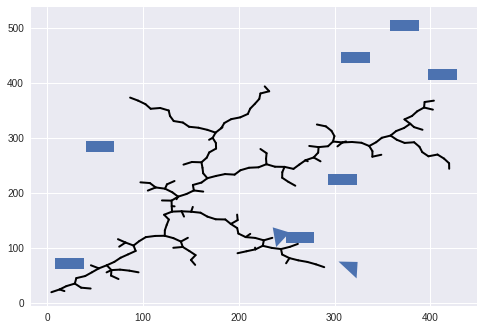

[<__main__.obstacle object at 0x7fc1ce9cea20>, <__main__.obstacle object at 0x7fc1ce9ce9e8>, <__main__.obstacle object at 0x7fc1ce9ce940>, <__main__.obstacle object at 0x7fc1ce9e7dd8>, <__main__.obstacle object at 0x7fc1ce9e7eb8>, <__main__.obstacle object at 0x7fc1ce9e7e10>, <__main__.obstacle object at 0x7fc1ce9e7e48>, <__main__.obstacle object at 0x7fc1ce9e7ef0>, <__main__.obstacle object at 0x7fc1ce9e7f28>]
Did not reach the goal co-ordinates


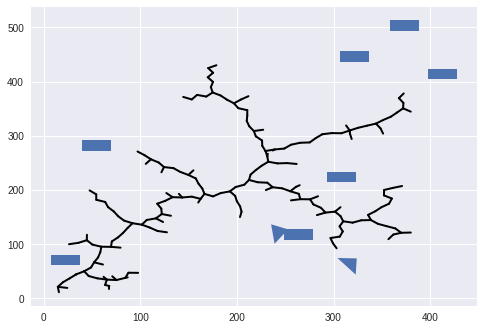

[<__main__.obstacle object at 0x7fc1ce9cea20>, <__main__.obstacle object at 0x7fc1ce9ce9e8>, <__main__.obstacle object at 0x7fc1ce9ce940>, <__main__.obstacle object at 0x7fc1ce9e7dd8>, <__main__.obstacle object at 0x7fc1ce9e7eb8>, <__main__.obstacle object at 0x7fc1ce9e7e10>, <__main__.obstacle object at 0x7fc1ce9e7e48>, <__main__.obstacle object at 0x7fc1ce9e7ef0>, <__main__.obstacle object at 0x7fc1ce9e7f28>]
Did not reach the goal co-ordinates


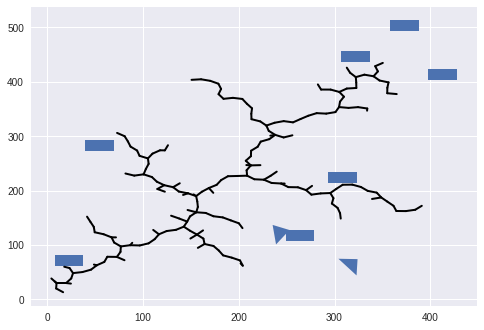

[<__main__.obstacle object at 0x7fc1ce9cea20>, <__main__.obstacle object at 0x7fc1ce9ce9e8>, <__main__.obstacle object at 0x7fc1ce9ce940>, <__main__.obstacle object at 0x7fc1ce9e7dd8>, <__main__.obstacle object at 0x7fc1ce9e7eb8>, <__main__.obstacle object at 0x7fc1ce9e7e10>, <__main__.obstacle object at 0x7fc1ce9e7e48>, <__main__.obstacle object at 0x7fc1ce9e7ef0>, <__main__.obstacle object at 0x7fc1ce9e7f28>]
Did not reach the goal co-ordinates


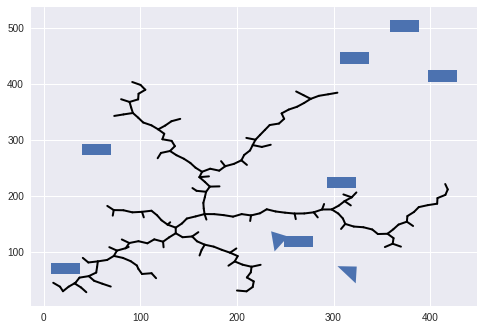

In [141]:
running_times = []
iters=[]
fig,ax = plt.subplots()
for sz in [5,10,20,40,60]:
  s_time = getCurrentTime()
  build_holonomic_rrt(n_iter=200,start=start,goal=goal,obstacles = obstacles,step_size=10)
  plt.show()
  e_time = getCurrentTime()
  running_times.append(e_time-s_time)
  iters.append(sz)

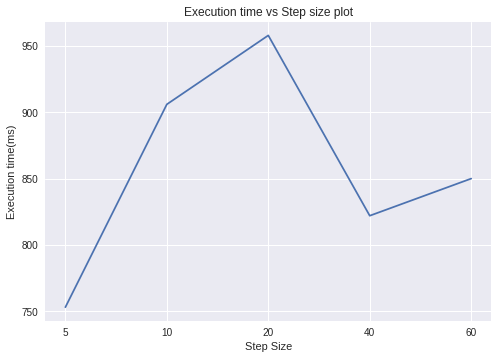

In [142]:
plt.xticks(range(len(running_times)),iters)
plt.xlabel('Step Size')
plt.ylabel('Execution time(ms)')
plt.title('Execution time vs Step size plot')
plt.plot(range(len(running_times)), running_times)


Did not reach the goal co-ordinates


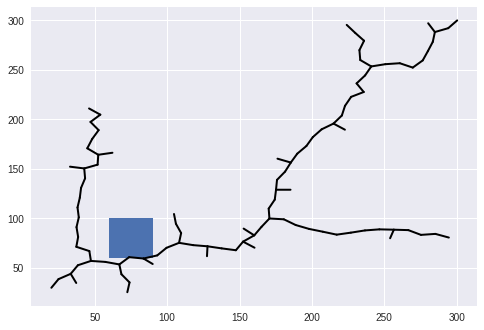

[<__main__.obstacle object at 0x7fc1db134b70>, <__main__.obstacle object at 0x7fc1d9d4cb70>]
Did not reach the goal co-ordinates


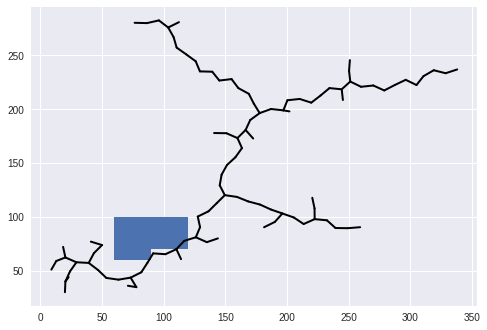

[<__main__.obstacle object at 0x7fc1db134b70>, <__main__.obstacle object at 0x7fc1d9d4cb70>, <__main__.obstacle object at 0x7fc1dd5ac438>]
Did not reach the goal co-ordinates


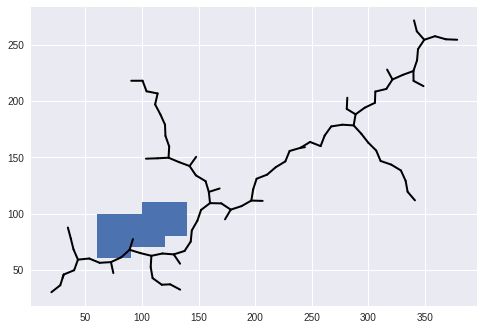

[<__main__.obstacle object at 0x7fc1db134b70>, <__main__.obstacle object at 0x7fc1d9d4cb70>, <__main__.obstacle object at 0x7fc1dd5ac438>, <__main__.obstacle object at 0x7fc1dd5ac780>]
Did not reach the goal co-ordinates


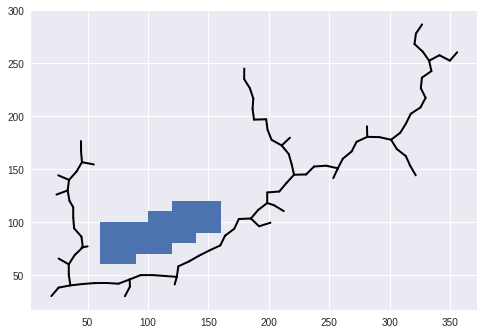

[<__main__.obstacle object at 0x7fc1db134b70>, <__main__.obstacle object at 0x7fc1d9d4cb70>, <__main__.obstacle object at 0x7fc1dd5ac438>, <__main__.obstacle object at 0x7fc1dd5ac780>, <__main__.obstacle object at 0x7fc1bfb3fbe0>]
Did not reach the goal co-ordinates


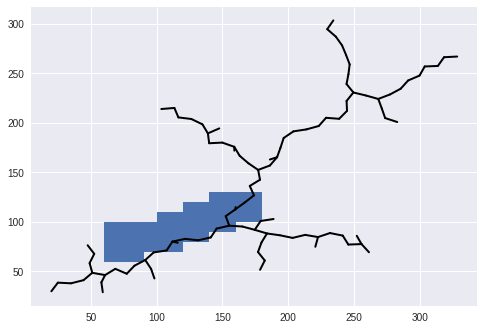

In [143]:
running_times = []
iters=[]
fig,ax = plt.subplots()
o = obstacle(1,60,60,30,30,40)
tobs = [o]
for no in [1,2,3,4,5]:
  s_time = getCurrentTime()
  build_holonomic_rrt(n_iter=100,start=start,goal=goal,obstacles = tobs,step_size=10)
  plt.show()
  e_time = getCurrentTime()
  running_times.append(e_time-s_time)
  iters.append(no)
  to = obstacle(1,tobs[no-1].xa+20,tobs[no-1].ya+10,30+(5*no),40,30)
  tobs.append(to)

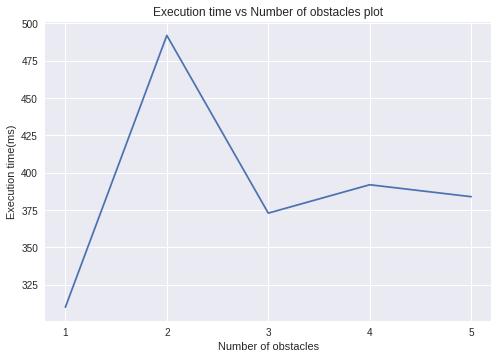

In [144]:
plt.xticks(range(len(running_times)),iters)
plt.xlabel('Number of obstacles')
plt.ylabel('Execution time(ms)')
plt.title('Execution time vs Number of obstacles plot')
plt.plot(range(len(running_times)), running_times)


### **Results**
- The performance of RRT for holonomic motion is much faster than nonholonomic motion since there is an absence of integration of any function.
- The number of iterations required to reach the goal is slightly lower than that of holonomic motion but since it is random this may not hold true for every case.
- The time required for every iteration also varies due to randomness. In most cases it is low, but for edge cases where the new points are obtained on obstacle with higher probability may require more time for execution.
- On an average for 2 obstacles and farther spread start and goal points, an average of 200 iterations are required. Increasing the obstacles will increase the number of iterations and the time required.
- Goal bias should be applied, this will push the performance to higher limits.